In [2]:
!pip install wandb

In [3]:
import os
import math
import random

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.datasets import imdb

import wandb
from wandb.keras import WandbMetricsLogger

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [4]:
# num_classes = 10
# num_features = 32 * 32

lr = 0.1
n_epochs = 20
batch_size = 256

In [5]:
wandb.init(project="2023-08-03_test_2", config={"lr": lr, "n_epochs": n_epochs, "batch_size": batch_size})

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [6]:
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    os.environ["TF_DETERMINISTIC_OPS"] = "true"
    

set_seed(42)

In [7]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17464789/17464789 [==============================] - 0s 0us/step


In [8]:
word_index = imdb.get_word_index()

1641221/1641221 [==============================] - 0s 0us/step


In [9]:
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [10]:
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

In [11]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [12]:
# [5, 9, 3, 1, 9]
# [0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0]

In [13]:
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, X, y, shuffle=True, batch_size=256):
        self.X = X
        self.y = y
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.X))
        self.batch_size = batch_size
        
        if shuffle:
            self.on_epoch_end()
    
    def __len__(self):
        return math.ceil(len(self.X) / self.batch_size)
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_X_row = [self.X[i] for i in indexes]
        batch_y = [self.y[i] for i in indexes]
        
        batch_X = []
        for i in range(min(self.batch_size, len(indexes))):
            new_vector = [0] * 10000
            for elem in batch_X_row[i]:
                new_vector[elem] = 1
            batch_X.append(new_vector)
        
        return np.array(batch_X), np.array(batch_y)
        
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [14]:
train_dataset = Dataset(train_data, train_labels, shuffle=True, batch_size=2)

In [15]:
X, y = train_dataset[0]
X.shape, y.shape

((2, 10000), (2,))

In [16]:
# ids = [...]
# y = [0, 0, 0, 0, 1, 1, 1, 0, 1]
# i = [1, 4, 2, 7, 9, 0, 8, 5, 6]

# ids[i[0:2]] - ids[[1, 4]]
# y[i[0:2]] - y[[2, 7]]

# batch_size = 2
# i[0:2] - [1, 4] - [0, 1]
# i[2:4] - [2, 7] - [0, 0]
# i[4:6] - [9, 0] - [1, 0]

In [17]:
train_dataset = Dataset(train_data, train_labels, shuffle=True, batch_size=batch_size)
valid_dataset = Dataset(test_data, test_labels, shuffle=False, batch_size=batch_size)

len(train_dataset)

98

In [18]:
model = Sequential(
    [
        Dense(1024, activation="relu", input_shape=(10000,)),
        Dense(1024, activation="relu"),
        Dense(1024, activation="relu"),
        Dense(1, activation="sigmoid"),
    ]
)

In [19]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Accuracy

model.compile(
    optimizer=Adam(lr=lr),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callback_early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=2,
    verbose=1,
    mode="max",
)

callback_save = ModelCheckpoint(
    "best.hdf5",
    monitor="val_loss",
    save_best_only=True,
)

In [21]:
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=n_epochs,
    verbose=1,
    callbacks=[callback_early_stopping, WandbMetricsLogger()]
)

Epoch 1/20
98/98 [==============================] - 90s 851ms/step - loss: 0.3400 - accuracy: 0.8435 - val_loss: 0.2798 - val_accuracy: 0.8838
Epoch 2/20
98/98 [==============================] - 78s 795ms/step - loss: 0.0979 - accuracy: 0.9652 - val_loss: 0.3669 - val_accuracy: 0.8601
Epoch 3/20
98/98 [==============================] - 80s 817ms/step - loss: 0.0182 - accuracy: 0.9942 - val_loss: 0.6632 - val_accuracy: 0.8671
Epoch 3: early stopping


In [23]:
model.save_weights("my_model.hdf5")

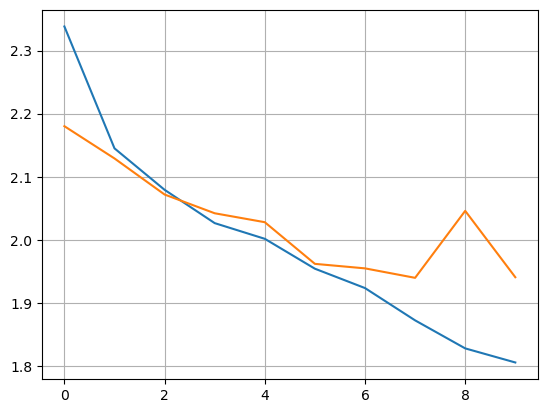

In [74]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="valid loss")
plt.grid()

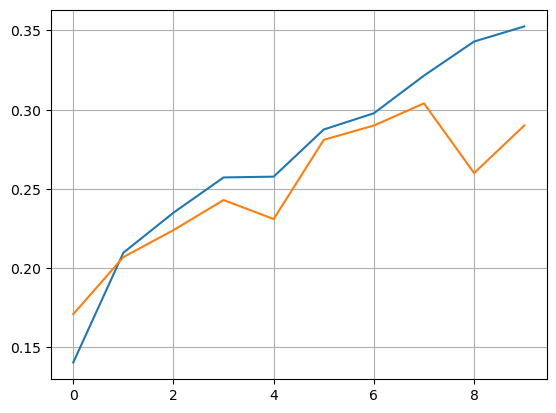

In [75]:
plt.plot(history.history["accuracy"], label="train loss")
plt.plot(history.history["val_accuracy"], label="valid loss")
plt.grid()

In [ ]:
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}

In [27]:
print(test_data[0])

[1, 591, 202, 14, 31, 6, 717, 10, 10, 2, 2, 5, 4, 360, 7, 4, 177, 5760, 394, 354, 4, 123, 9, 1035, 1035, 1035, 10, 10, 13, 92, 124, 89, 488, 7944, 100, 28, 1668, 14, 31, 23, 27, 7479, 29, 220, 468, 8, 124, 14, 286, 170, 8, 157, 46, 5, 27, 239, 16, 179, 2, 38, 32, 25, 7944, 451, 202, 14, 6, 717]


In [31]:
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in test_data[0]])
decoded_review

"? please give this one a miss br br ? ? and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite ? so all you madison fans give this a miss"

In [36]:
tmp = [word_index.get(word, -2) + 3 for word in decoded_review.split(" ")]
print(tmp)

[1, 591, 202, 14, 31, 6, 717, 10, 10, 1, 1, 5, 4, 360, 7, 4, 177, 5760, 394, 354, 4, 123, 9, 1035, 1035, 1035, 10, 10, 13, 92, 124, 89, 488, 7944, 100, 28, 1668, 14, 31, 23, 27, 7479, 29, 220, 468, 8, 124, 14, 286, 170, 8, 157, 46, 5, 27, 239, 16, 179, 1, 38, 32, 25, 7944, 451, 202, 14, 6, 717]


In [37]:
new_vector = [0] * 10000
for elem in tmp:
    new_vector[elem] = 1

new_vector = np.array(new_vector).reshape(1, 10000)
model.predict(new_vector)

1/1 [==============================] - 0s 34ms/step


array([[0.00849102]], dtype=float32)

In [76]:
wandb.finish()

epoch/categorical_accuracy,▁▃▄▅▅▆▆▇██
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▅▄▄▃▃▂▁▁
epoch/val_categorical_accuracy,▁▃▄▅▄▇▇█▆▇
epoch/val_loss,█▇▅▄▄▂▁▁▄▁
epoch/categorical_accuracy,0.3525
epoch/epoch,9
epoch/learning_rate,0.001
epoch/loss,1.8058
epoch/val_categorical_accuracy,0.29


In [ ]:
# model = NN()
# optimizer = tf.optimizers.SGD(lr)
# train_dataset = Dataset(X_train, y_train)
# train_data = tf.data.Dataset.from_generator(train_dataset, output_types=(tf.float32, tf.uint8))
# train_data = train_data.batch(batch_size).prefetch(2)
# valid_dataset = Dataset(X_valid, y_valid)
# valid_data = tf.data.Dataset.from_generator(valid_dataset, output_types=(tf.float32, tf.uint8))
# valid_data = valid_data.batch(batch_size).prefetch(2)

# trainer = Trainer(model, optimizer, 8)
# e_train_loss, e_train_score, e_valid_loss, e_valid_score = trainer.fit(train_data, valid_data)

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(e_train_loss)
plt.plot(e_valid_loss)
plt.grid()

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(e_train_score)
plt.plot(e_valid_score)
plt.grid()

In [ ]:
df = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_test.csv")

In [ ]:
df

In [ ]:
x_test_sample = df.iloc[:4, 1:].values

In [ ]:
x_test_sample = x_test_sample.astype(np.float32)
x_test_sample /= 255.

In [ ]:
test_out = model(x_test_sample)

In [ ]:
test_out.numpy().argmax(axis=1)

In [ ]:
plt.figure(figsize=(8, 8))
for i, _x in enumerate(x_test_sample, 1):
    plt.subplot(2, 2, i)
    plt.imshow(_x.reshape(28, 28), cmap="gray")
    plt.title(f"Predict: {test_out.numpy().argmax(axis=1)[i - 1]} Real: {df.iloc[i-1, 0]}")

In [ ]:
x_test = df.iloc[:, 1:].values
x_test = x_test.astype(np.float32)
x_test /= 255.

In [ ]:
test_out = model(x_test).numpy()

In [ ]:
y_pred_test = test_out.argmax(axis=1)
y_test = df.iloc[:, 0].values

In [ ]:
np.mean(y_pred_test == y_test)

In [ ]:
arr = \
[
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
df_confusion_matrix = pd.DataFrame(cm, index=arr, columns=arr)

plt.figure(figsize=(8, 8))
sn.heatmap(df_confusion_matrix, fmt="d", annot=True, cbar=False, cmap="Oranges", linewidths=1, linecolor="black")
plt.xlabel("Predicted labels", fontsize=15)
plt.xticks(fontsize=10)
plt.ylabel("True labels", fontsize=15)
plt.yticks(fontsize=10, rotation=0);

In [ ]:
ea = pd.DataFrame({"pred": y_pred_test, "y": y_test})

In [ ]:
ea["equal"] = ea["pred"] == ea["y"]

In [ ]:
ea[(ea["y"] == 6) & (ea["equal"] == False)]

In [ ]:
plt.figure(figsize=(8, 8))
index = [7, 16, 43, 58]
for i, _x in enumerate(x_test[index], 1):
    plt.subplot(2, 2, i)
    plt.imshow(_x.reshape(28, 28), cmap="gray")
    plt.title(f"Predict: {arr[y_pred_test[index[i - 1]]]} Real: {arr[y_test[index[i - 1]]]}")

In [ ]:
, 1